<a href="https://colab.research.google.com/github/Devadeut/Neural-Networks-Hands-On-Projects/blob/main/Stringer%20Dataset/load_stringer_spontaneous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore


from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import  FactorAnalysis

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [ ]:
print(dat['sresp'][0])

[ 2.9820833  8.409119  12.720393  ...  0.        11.900859   7.5612717]


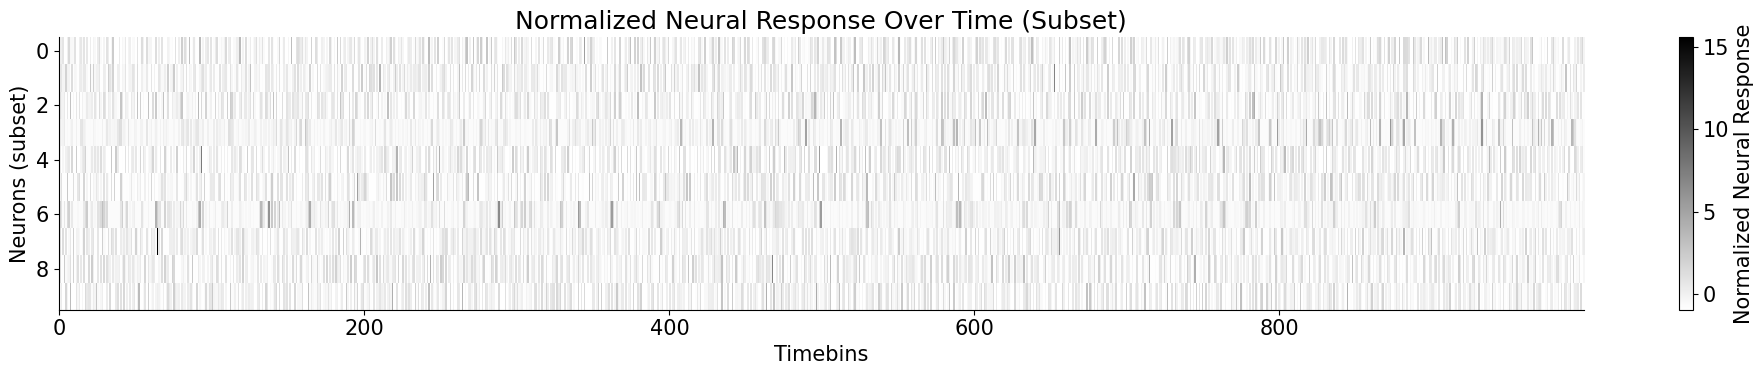

In [ ]:
# @title plot of neural response over time
sresp = dat['sresp']  # neurons by timebins

# Normalize data using z-score
sresp_normalized = stats.zscore(sresp, axis=1)

# Select a subset if the dataset is too large
# For example, the first 10 neurons and 1000 timebins
sresp_subset = sresp_normalized[:10, :1000]

# Plotting
plt.figure()
plt.imshow(sresp_subset, aspect='auto', cmap='gray_r', interpolation='none')
plt.colorbar(label='Normalized Neural Response')
plt.xlabel('Timebins')
plt.ylabel('Neurons (subset)')
plt.title('Normalized Neural Response Over Time (Subset)')
plt.show()

In [ ]:
# @title  dat['xyz]
print("x-axis : ", dat['xyz'][0])
print("y-axis : ", dat['xyz'][1])
print("z-axis : ", dat['xyz'][2])

x-axis :  [174. 220.  18. ... 806. 944. 938.]
y-axis :  [  6.   4.  16. ... 510. 638. 978.]
z-axis :  [-150. -150. -150. ... -390. -390. -390.]


In [ ]:
dat['pupilCOM'][0]

array([76.04868733, 48.48872503])

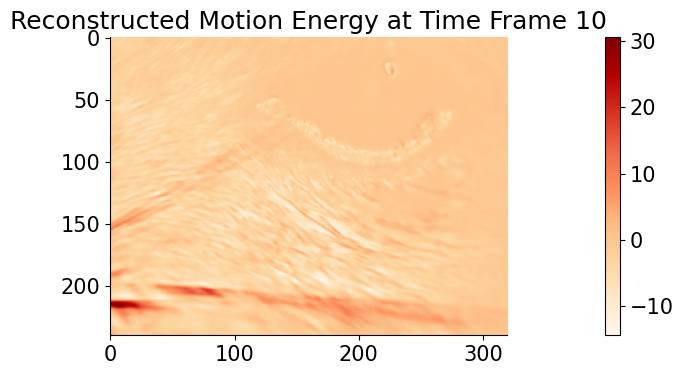

In [ ]:
# @title Reconstruct the face movie for frame T
reconstructed_movie = dat['beh_svd_mask'] @ dat['beh_svd_time'][10, :]

# Plot the reconstructed movie frame
plt.imshow(reconstructed_movie, cmap='OrRd')
plt.title(f"Reconstructed Motion Energy at Time Frame {10}")
plt.colorbar()
plt.show()

<ipython-input-13-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


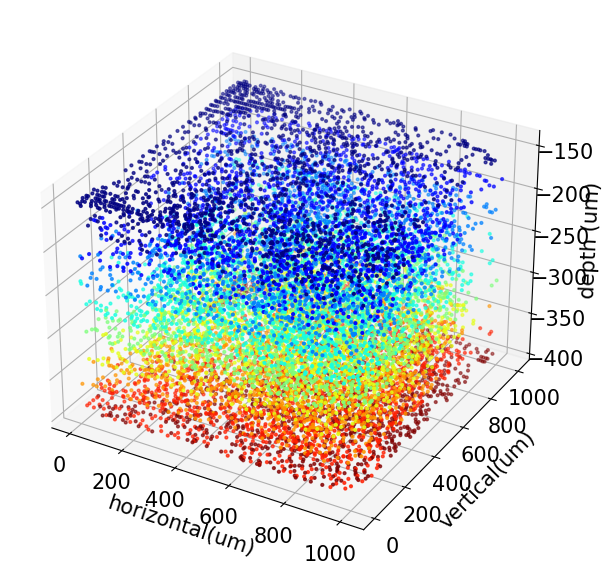

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

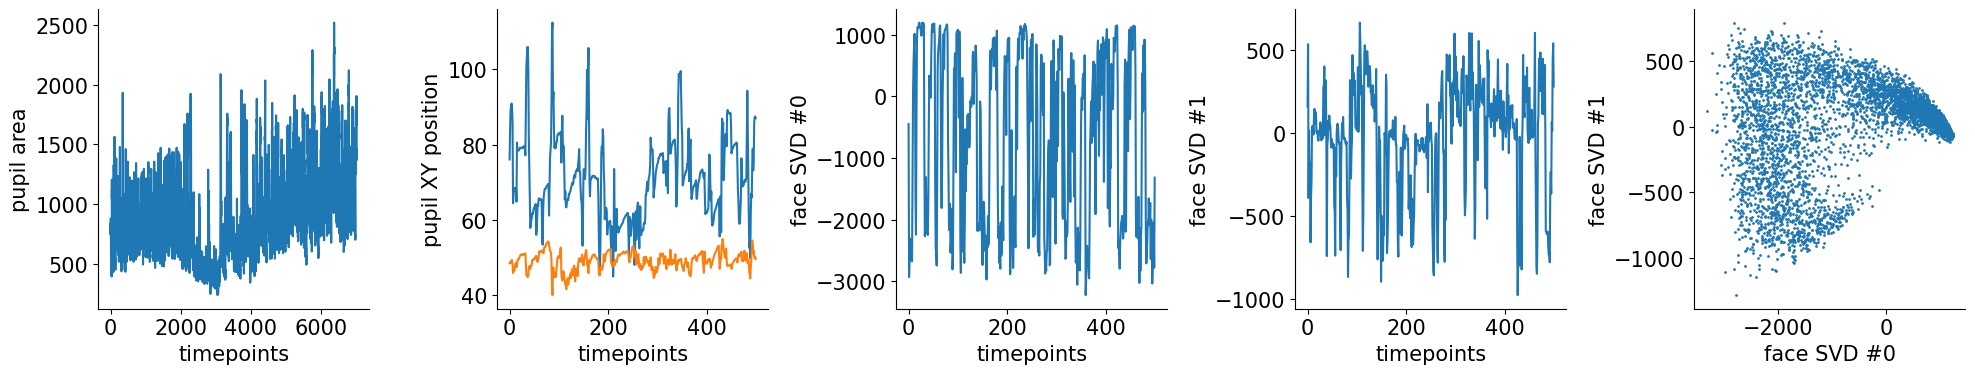

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 't-SNE Visualization of Dimensionality-Reduced Responses')

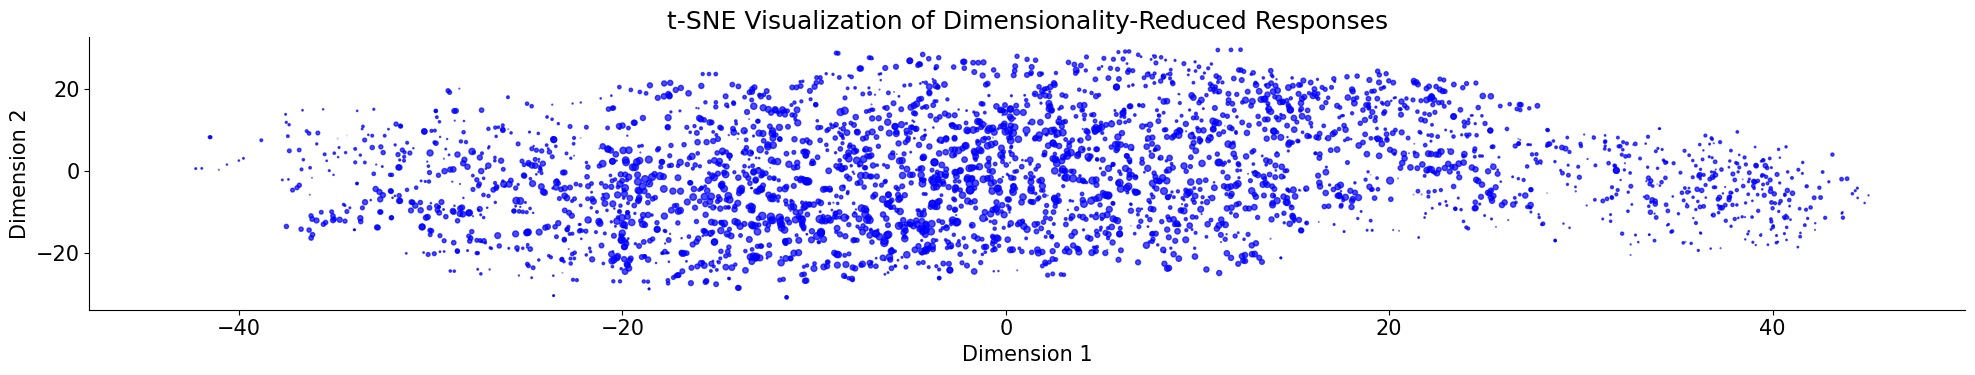

In [ ]:
# @title tSNE representation
from sklearn.manifold import TSNE
resp = dat['sresp']
#Z1 = zscore(resp.T, axis=1)
Z1 = np.nan_to_num(resp.T)
# First do PCA to reduce dimensionality to 20 dimensions so that tSNE is faster
resp_lowd_pca = PCA(n_components=min(200, resp.shape[1]), random_state=0).fit_transform(Z1)

# Then do tSNE to reduce dimensionality to 2 dimensions
resp_lowd_tsne = TSNE(n_components=3, random_state=0).fit_transform(resp_lowd_pca)

# Plot dimensionality-reduced population responses 'resp_lowd_tsne'
# on 2D axes, with all points colored in a single color (e.g., blue)

# Create a scatter plot with a single color
plt.scatter(resp_lowd_tsne[:, 0], resp_lowd_tsne[:, 1], resp_lowd_tsne[:, 2], color='blue', alpha=0.7)

# Set labels and title
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.zlabel('Dimension 3')
plt.title('t-SNE Visualization of Dimensionality-Reduced Responses')

In [ ]:
# Extract x and y coordinates
x = dat['pupilCOM'][:, 0]
y = dat['pupilCOM'][:, 1]

# Calculate the relative changes
rel_x = np.diff(x)
rel_y = np.diff(y)



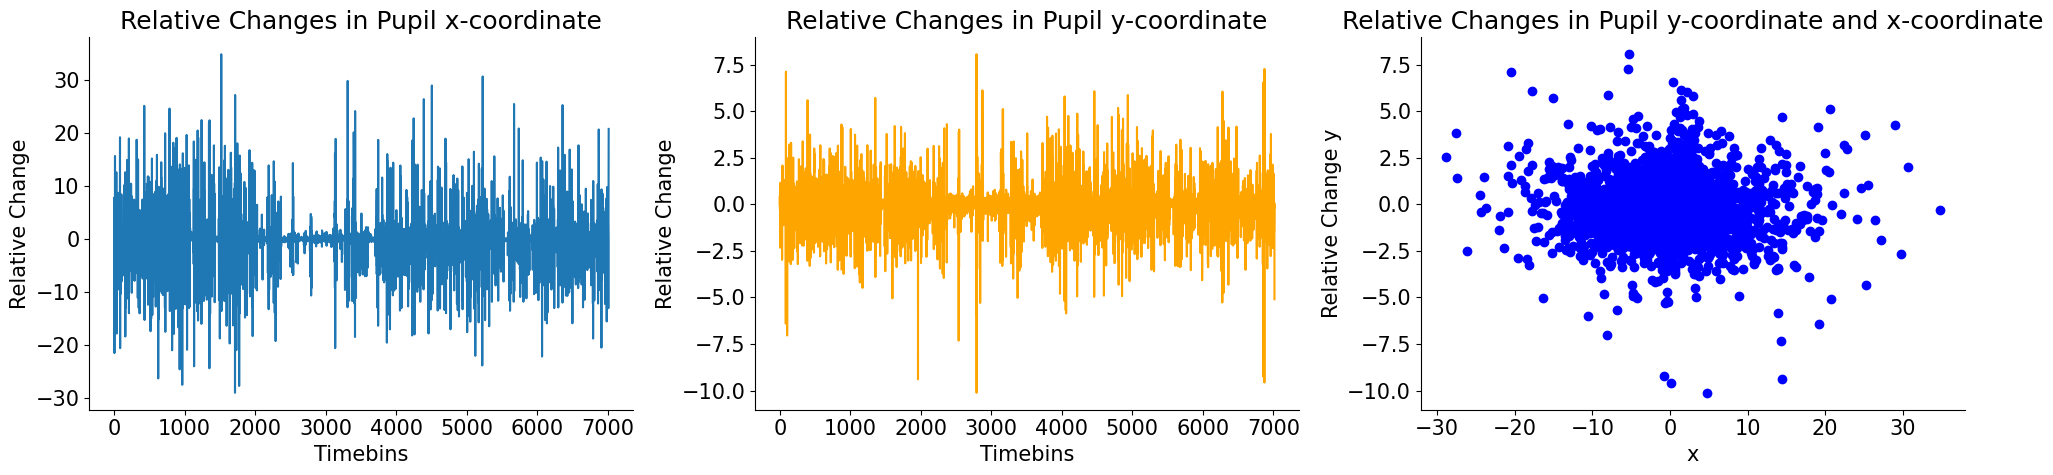

In [ ]:
# Plot the relative changes
plt.figure(figsize=(20, 5))

# Plot relative changes in x
plt.subplot(1, 3, 1)
plt.plot(rel_x, label='Relative Change in x')
plt.xlabel('Timebins')
plt.ylabel('Relative Change')
plt.title('Relative Changes in Pupil x-coordinate')

# Plot relative changes in y
plt.subplot(1, 3, 2)
plt.plot(rel_y, label='Relative Change in y', color='orange')
plt.xlabel('Timebins')
plt.ylabel('Relative Change')
plt.title('Relative Changes in Pupil y-coordinate')

# Plot relative changes in x and y
plt.subplot(1, 3, 3)
plt.scatter(rel_x,rel_y, label='Relative Change in x and y', color='blue')
plt.xlabel('x')
plt.ylabel('Relative Change y')
plt.title('Relative Changes in Pupil y-coordinate and x-coordinate')

# # Adjust layout for better visualization
# plt.tight_layout()

# Show the plot
plt.show()


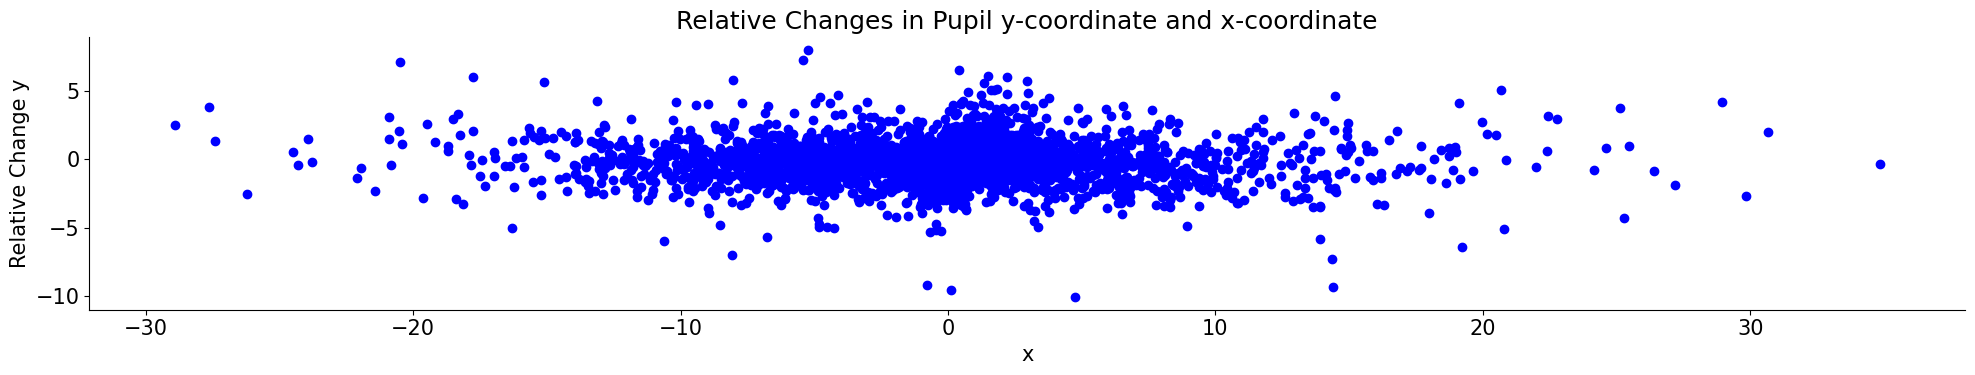

In [ ]:
# Plot relative changes in x and y
plt.scatter(rel_x,rel_y, label='Relative Change in x and y', color='blue')
plt.xlabel('x')
plt.ylabel('Relative Change y')
plt.title('Relative Changes in Pupil y-coordinate and x-coordinate')
plt.show()

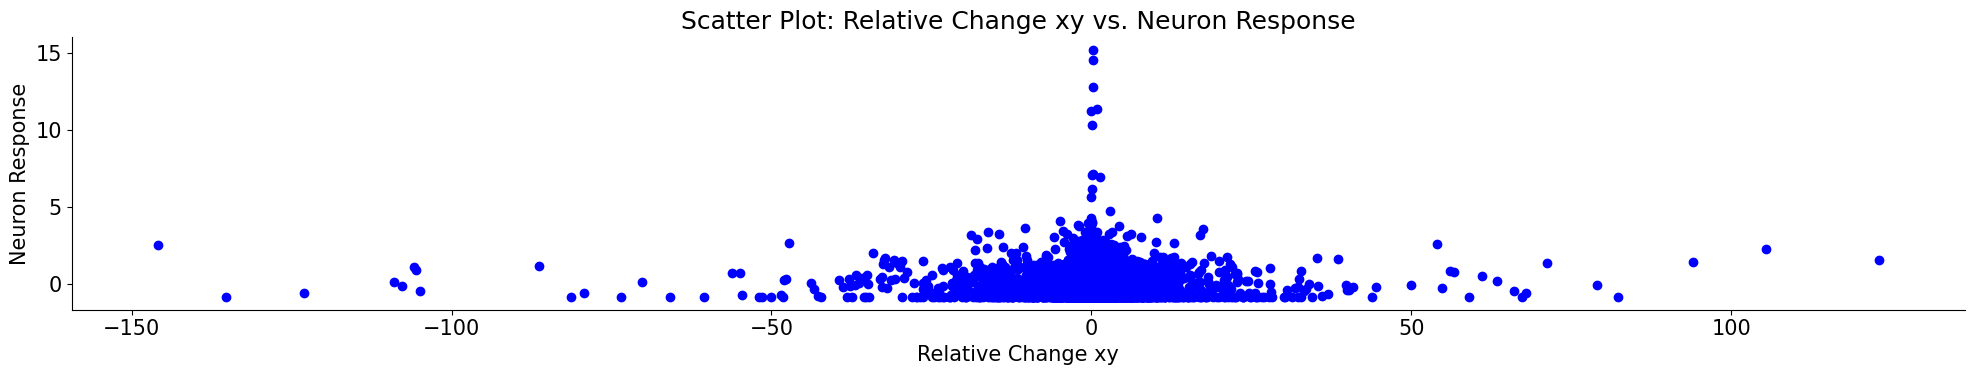

In [ ]:
# Trim or pad rel to make its length equal to sresp[0, :]
sresp_length = sresp.shape[1]
rel = np.pad((rel_x * rel_y), (0, sresp_length - len(rel_x) + 1), mode='constant', constant_values=0)[:sresp_length]

#plt.figure(figsize=(20, 15))
# Scatter plot
plt.scatter( rel,Z[8, :], label='Relative Change xy and neuron response', color='blue')
plt.ylabel('Neuron Response')
plt.xlabel('Relative Change xy')
plt.title('Scatter Plot: Relative Change xy vs. Neuron Response')

# Show the plot
plt.show()


# Models

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
# @title Import

In [ ]:
# @title Subsetting Neural Data According to Depth Information
def unique(list1):
    list_set = set(list1)
    unq = (list(list_set))
    return unq
depth_values = unique(dat['xyz'][2].tolist())
depth_subsets = {}
layer = 0
for depth in depth_values:
    layer = layer + 1
    depth_indices = []
    depth_indices = (dat['xyz'][2] == depth)
    depth_subsets[layer] = dat['sresp'][depth_indices]

In [26]:

D.shape, Y.shape

((7018,), (7018, 2))

In [29]:
Z = zscore(depth_subsets[1].T, axis=1)
X = np.nan_to_num(Z)

x_change = np.diff(dat['pupilCOM'][:,0])
y_change = np.diff(dat['pupilCOM'][:,1])
Y = np.vstack((x_change,y_change)).T
Y = np.vstack((np.array([0,0]), Y))
Y = np.nan_to_num(Y)

D = np.sqrt(x_change**2 + y_change**2)
D = np.concatenate(([0], D))
D = np.nan_to_num(D)

tscv = TimeSeriesSplit(n_splits=5, gap=0)
for train_ix, test_ix in tscv.split(X):
      train_ix, test_ix


X_train = X[train_ix]
X_test = X[test_ix]
Y_train = D[train_ix]
Y_test = D[test_ix]


#GLM model
model = linear_model.LinearRegression()
model.fit(X_train,Y_train)
#model = sm.GLM(family=sm.families.Poisson())
#result = model.fit()
y_pred = model.predict(X_test)


mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)



mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
medianae = median_absolute_error(Y_test, y_pred)
evs = explained_variance_score(Y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Median Absolute Error: {medianae}')
print(f'Explained Variance Score: {evs}')
# @title LinearRegressor Distance

Mean Absolute Error: 1.9572818100931462
Mean Squared Error: 7.273210358876405
R-squared: 0.3546781825182781
Median Absolute Error: 1.4518337349571089
Explained Variance Score: 0.3606115679630907


[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


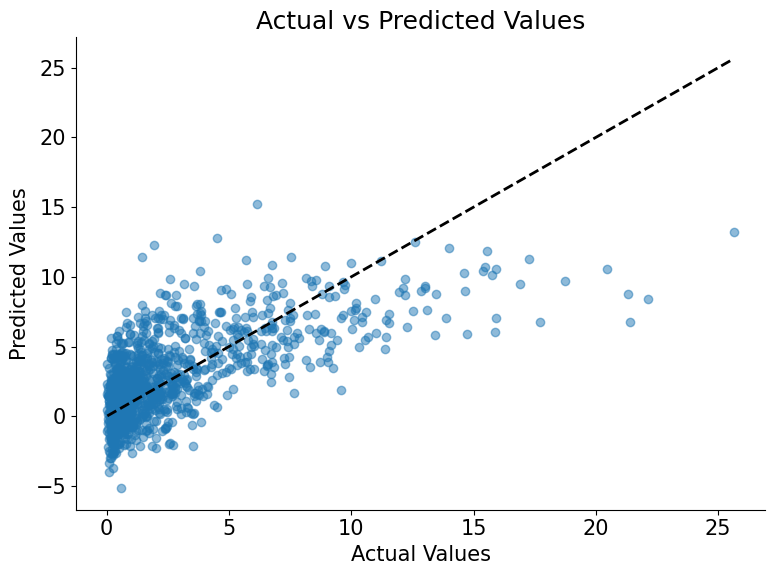

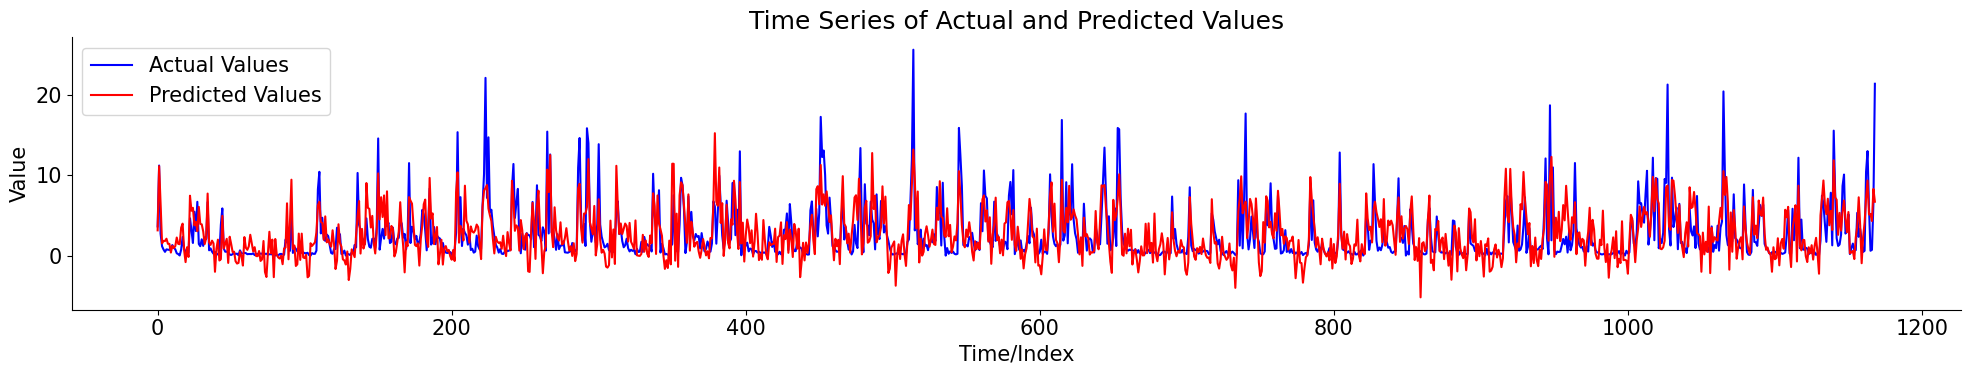

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


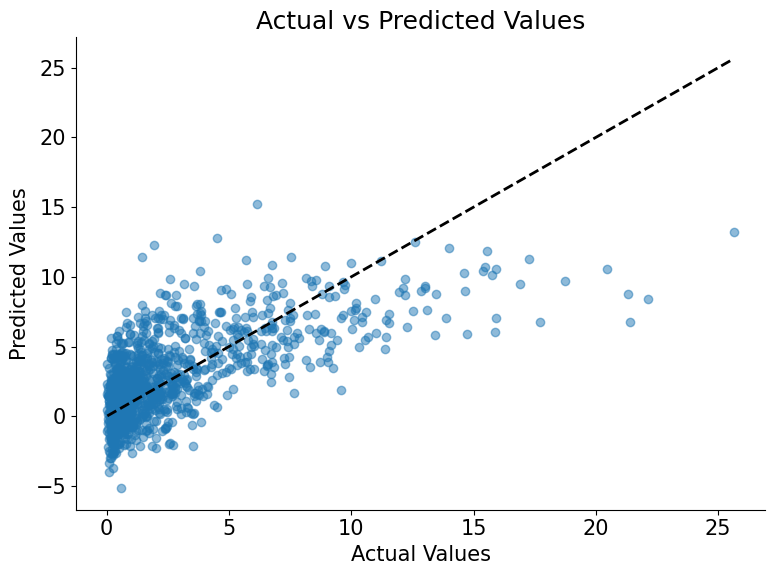

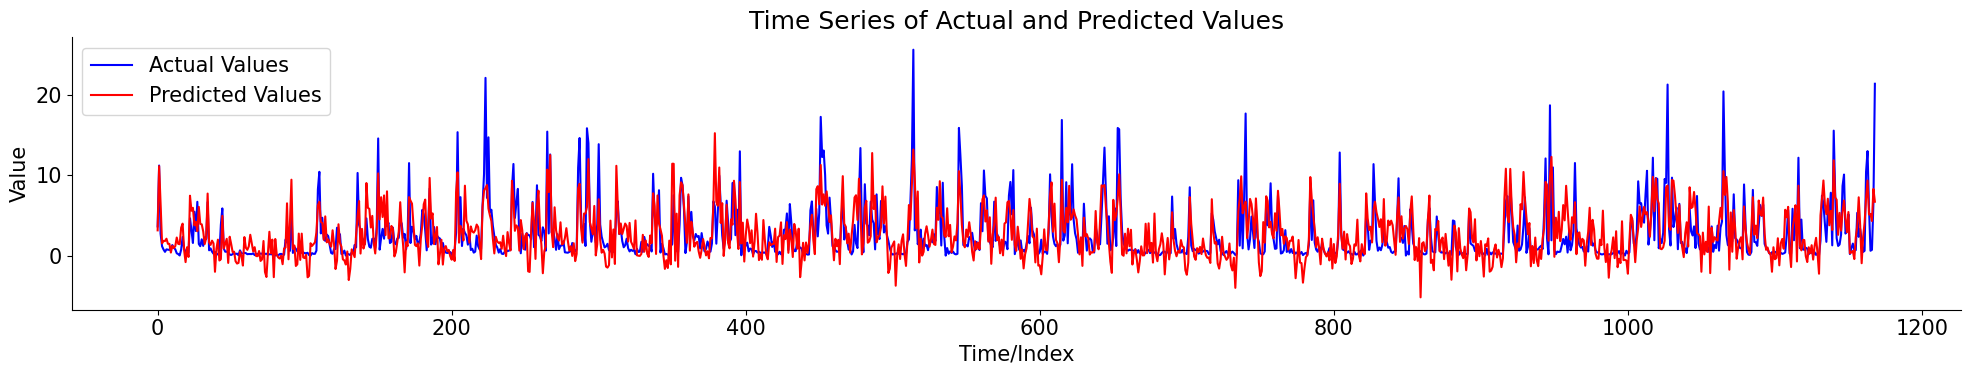

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


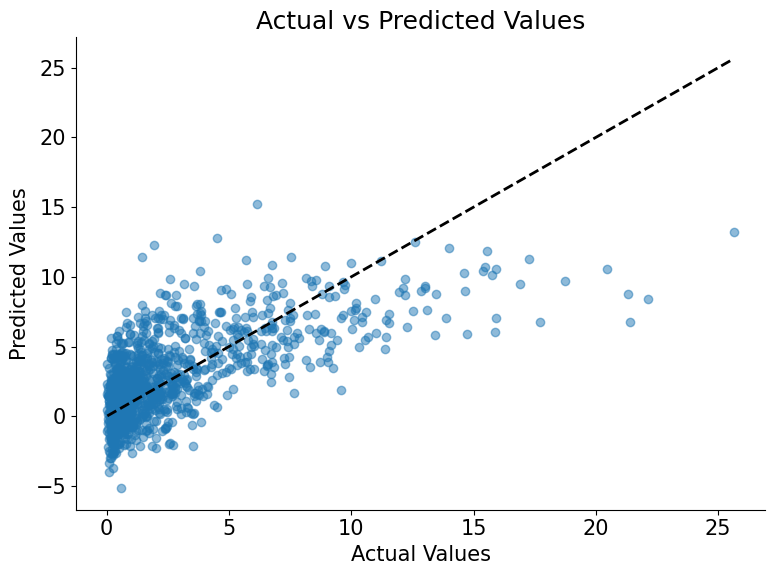

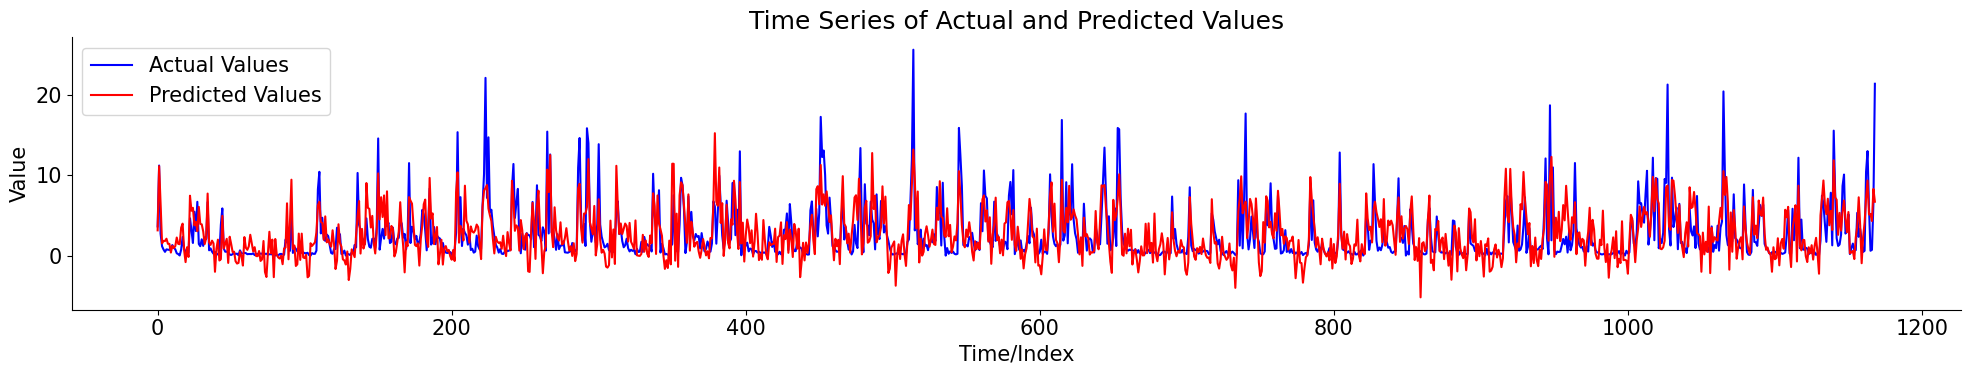

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


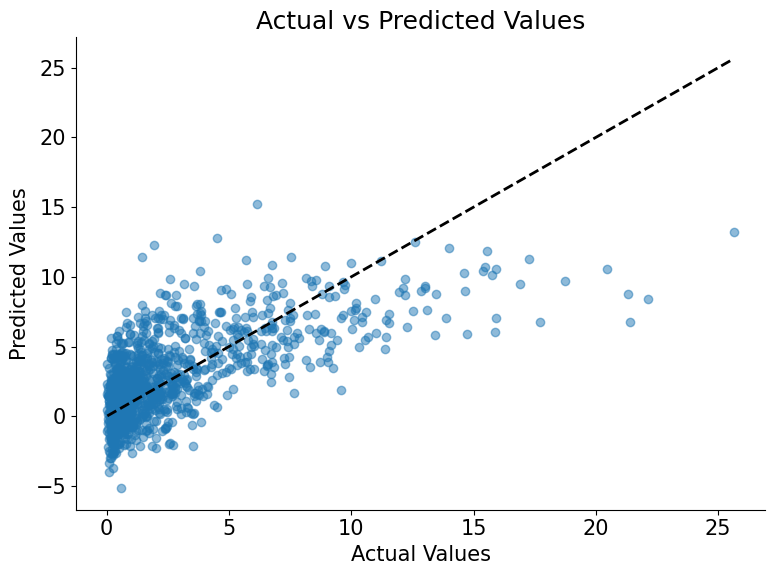

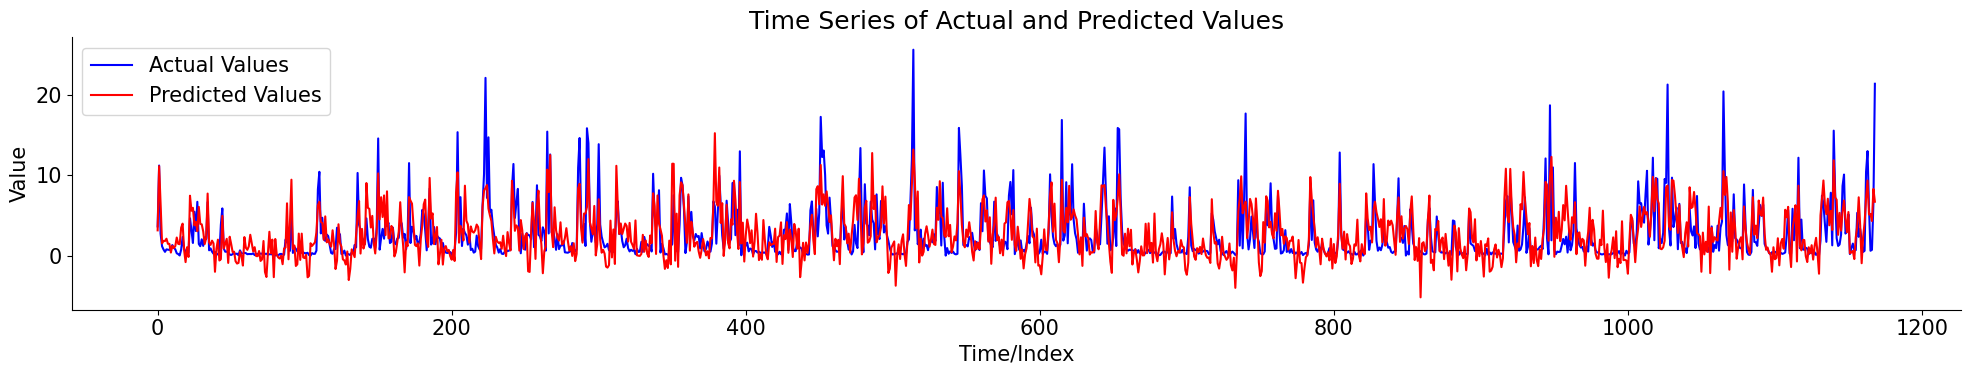

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


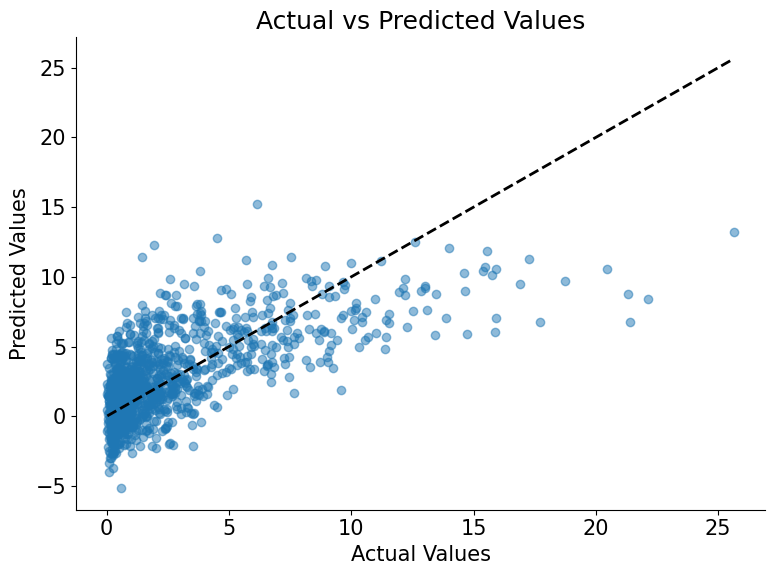

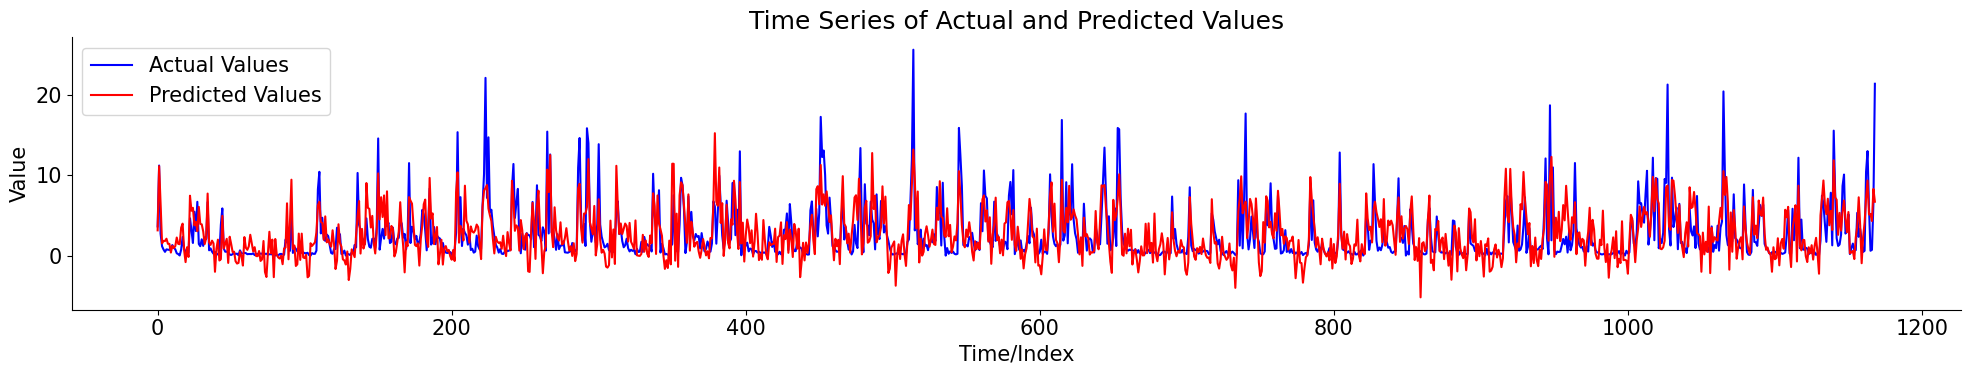

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


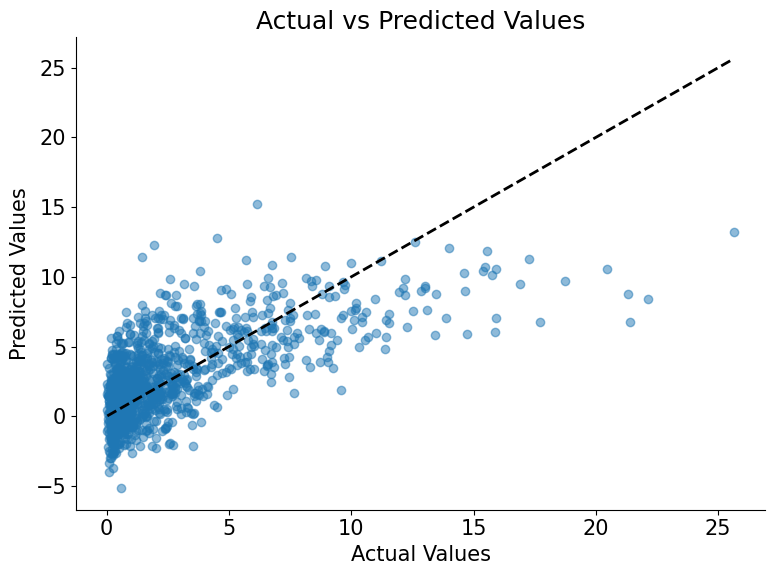

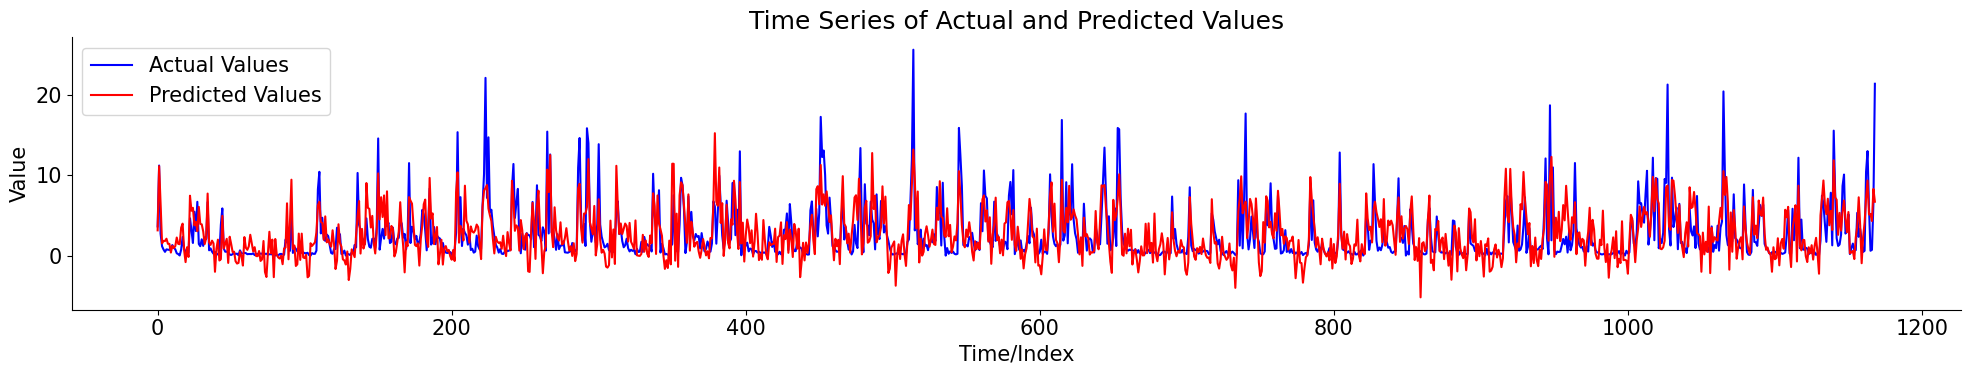

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


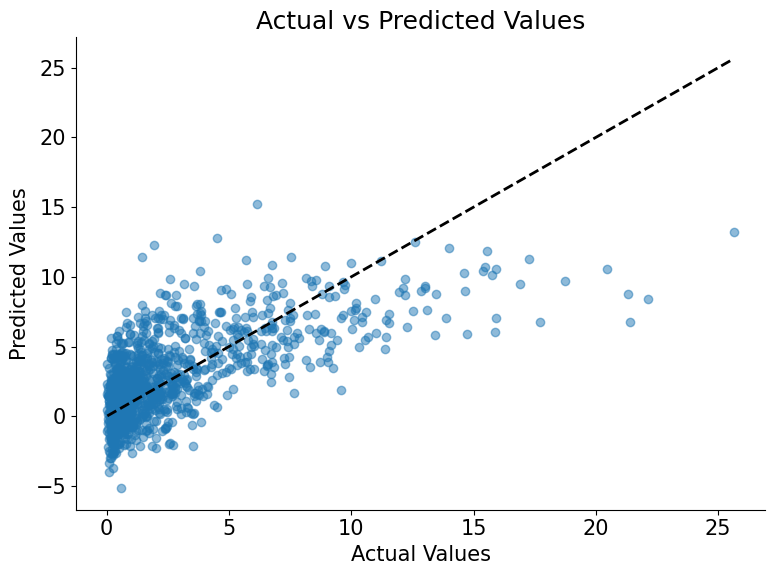

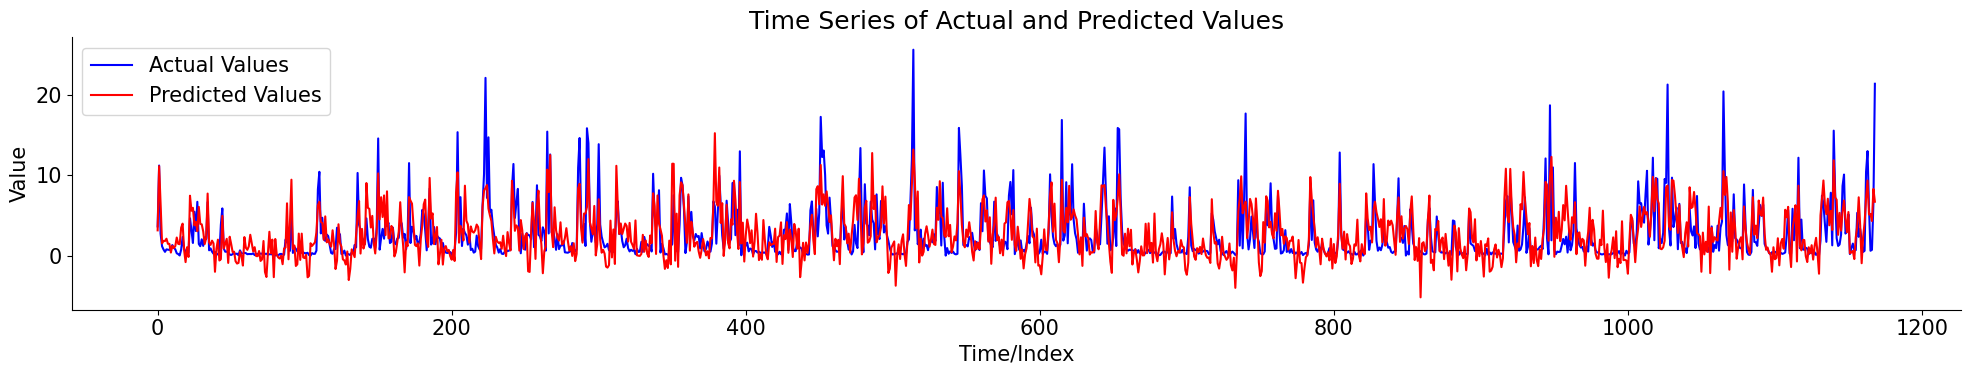

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


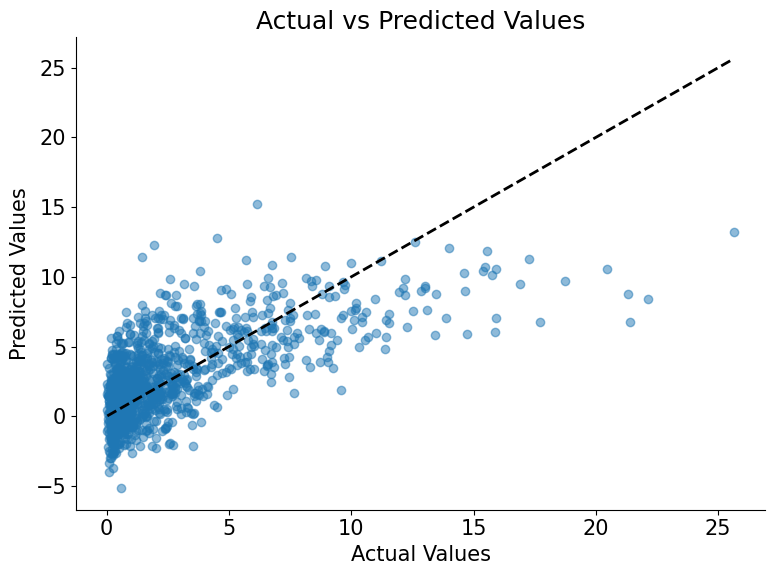

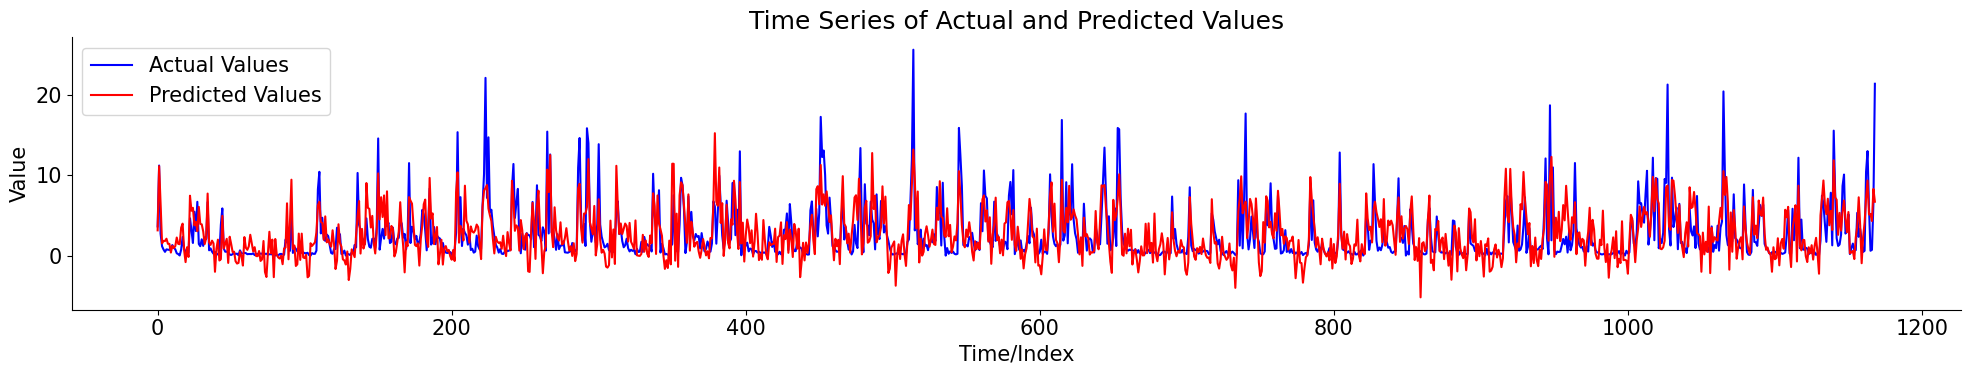

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]
Mean Absolute Error: 1.9351952070076475
Mean Squared Error: 6.881733753073977
R-squared: 0.389412279607837
Median Absolute Error: 1.4864351503287998
Explained Variance Score: 0.3922751485909688


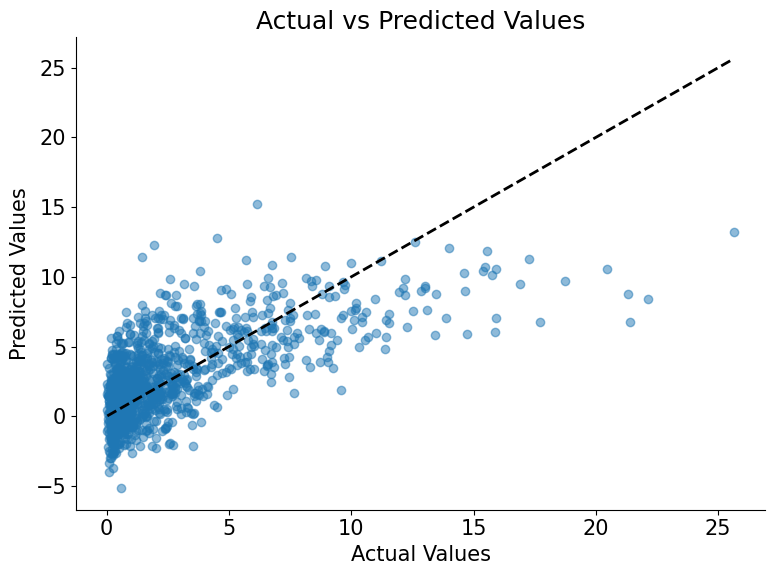

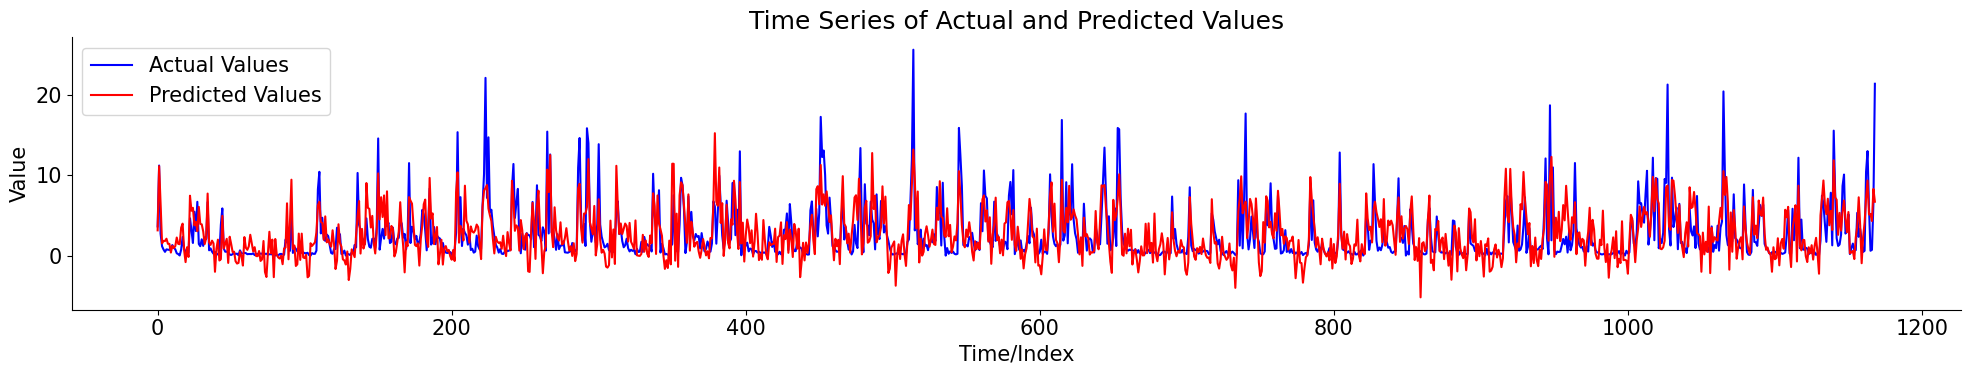

In [27]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import TimeSeriesSplit

#  Subsetting Neural Data According to Depth Information
def unique(list1):
    list_set = set(list1)
    unq = (list(list_set))
    return unq
depth_values = unique(dat['xyz'][2].tolist())
depth_subsets = {}
layer = 0
for depth in depth_values:
    layer = layer + 1
    depth_indices = []
    depth_indices = (dat['xyz'][2] == depth)
    depth_subsets[layer] = dat['sresp'][depth_indices]

all_layer_fold_metrics = {}



# Extract x and y coordinates
x = dat['pupilCOM'][:, 0]
y = dat['pupilCOM'][:, 1]

# Calculate the relative changes
rel_x = np.diff(x)
rel_y = np.diff(y)

for layer in depth_subsets:
        Z = zscore(depth_subsets[2].T, axis=1)
        X = np.nan_to_num(Z)

        x_change = np.diff(dat['pupilCOM'][:,0])
        y_change = np.diff(dat['pupilCOM'][:,1])
        Y = np.vstack((x_change,y_change)).T
        Y = np.vstack((np.array([0,0]), Y))
        Y = np.nan_to_num(Y)

        D = np.sqrt(x_change**2 + y_change**2)
        D = np.concatenate(([0], D))
        D = np.nan_to_num(D)

        fold_count = 0
        tscv = TimeSeriesSplit(n_splits=5, gap=0)
        for train_ix, test_ix in tscv.split(X):
              print(train_ix, test_ix)
              fold_count+=1

        # Initialize lists to store metrics for each fold
        fold_metrics = {
            'mse': [],
            'r2': [],
            'mae': [],
            'medianae': [],
            'evs': []
        }

        X_train = X[train_ix]
        X_test = X[test_ix]
        Y_train = D[train_ix]
        Y_test = D[test_ix]


        #GLM model
        model = linear_model.LinearRegression()
        model.fit(X_train,Y_train)
        #model = sm.GLM(family=sm.families.Poisson())
        #result = model.fit()
        y_pred = model.predict(X_test)


        mse = mean_squared_error(Y_test, y_pred)
        r2 = r2_score(Y_test, y_pred)



        mse = mean_squared_error(Y_test, y_pred)
        r2 = r2_score(Y_test, y_pred)
        mae = mean_absolute_error(Y_test, y_pred)
        medianae = median_absolute_error(Y_test, y_pred)
        evs = explained_variance_score(Y_test, y_pred)

        # Store metrics for each fold
        fold_metrics['mse'].append(mean_squared_error(Y_test, y_pred))
        fold_metrics['r2'].append(r2_score(Y_test, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(Y_test, y_pred))
        fold_metrics['medianae'].append(median_absolute_error(Y_test, y_pred))
        fold_metrics['evs'].append(explained_variance_score(Y_test, y_pred))

        # Store the fold metrics for each layer
        all_layer_fold_metrics[layer] = fold_metrics

        print(f'Mean Absolute Error: {mae}')
        print(f'Mean Squared Error: {mse}')
        print(f'R-squared: {r2}')
        print(f'Median Absolute Error: {medianae}')
        print(f'Explained Variance Score: {evs}')





        # Scatter plot of actual vs predicted values
        plt.figure(figsize=(8, 6))
        plt.scatter(Y_test, y_pred, alpha=0.5)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')
        plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)  # Diagonal line
        plt.show()

        # Time series plot of actual and predicted values

        plt.plot(Y_test, label='Actual Values', color='blue')
        plt.plot(y_pred, label='Predicted Values', color='red')
        plt.xlabel('Time/Index')
        plt.ylabel('Value')
        plt.title('Time Series of Actual and Predicted Values')
        plt.legend()
        plt.show()



# @title LinearRegressor Distance Visualization

In [ ]:
D.shape, resp_lowd_tsne.shape, Z1.shape


In [ ]:
#Z = zscore(depth_subsets[1].T, axis=1)
Z1 = zscore(resp_lowd_tsne)
X = np.nan_to_num(Z1)

x_change = np.diff(dat['pupilCOM'][:,0])
y_change = np.diff(dat['pupilCOM'][:,1])
Y = np.vstack((x_change,y_change)).T
Y = np.vstack((np.array([0,0]), Y))
Y = np.nan_to_num(Y)

D = np.sqrt(x_change**2 + y_change**2)
D = np.concatenate(([0], D))
D = np.nan_to_num(D)

tscv = TimeSeriesSplit(n_splits=2, gap=0)
for train_ix, test_ix in tscv.split(X):
  print(train_ix, test_ix)


X_train = X[train_ix]
X_test = X[test_ix]
Y_train = D[train_ix]
Y_test = D[test_ix]


#GLM model
model = linear_model.LinearRegression()
model.fit(X_train,Y_train)
#model = sm.GLM(family=sm.families.Poisson())
#result = model.fit()
y_pred = model.predict(X_test)


mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)



mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
medianae = median_absolute_error(Y_test, y_pred)
evs = explained_variance_score(Y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Median Absolute Error: {medianae}')
print(f'Explained Variance Score: {evs}')

# @title LinearRegressor with Dimensionality Reduction pca 20, tSNE 2

In [ ]:
model2 = SGDRegressor()
model2.fit(X_train, Y_train)
y_pred2 = model2.predict(X_test)


mse2 = mean_squared_error(Y_test, y_pred2)
r22 = r2_score(Y_test, y_pred2)
mae2 = mean_absolute_error(Y_test, y_pred2)
medianae2 = median_absolute_error(Y_test, y_pred2)
evs2 = explained_variance_score(Y_test, y_pred2)

print(f'Mean Absolute Error: {mae2}')
print(f'Mean Squared Error: {mse2}')
print(f'R-squared: {r22}')
print(f'Median Absolute Error: {medianae2}')
print(f'Explained Variance Score: {evs2}')

# @title SGDRegressor